In [2]:
%matplotlib inline

import time
from functools import partial
from typing import *

import numpy as np
import scipy as sp   # scipy is a popular scientific computing library for Python
import scipy.stats   # statistics package
import matplotlib.pyplot as plt

from ase import Atoms
from ase.calculators.mopac import MOPAC
from ase.io import read, write
from ase.visualize import view

import jax
import jax.numpy as jnp
from jaxlib.xla_extension import DeviceArray

/Users/dehuang/.pyenv/versions/3.9.6/lib/python3.9/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Variational Inference, Scaling, and Gaussian Processes

## Goal

1. Introduce the common problem of **scaling** and **tractability**.
2. Introduce the idea of **variational inference** which is an attempt at solving a tractability issue.
3. Introduce a "scalable" Gaussian Process based on variational inference [https://proceedings.neurips.cc/paper/2021/file/32bbf7b2bc4ed14eb1e9c2580056a989-Paper.pdf](https://proceedings.neurips.cc/paper/2021/file/32bbf7b2bc4ed14eb1e9c2580056a989-Paper.pdf)

## Scaling and Tractability: Motivating Approximations

### Scaling

1. **Scaling** is arguably the most important aspect of "practical" computer science and is what separates it from pure discrete mathematics.
2. Each computation takes a certain amount of time and memory in some relation to the size of an input.
3. This relationship is captured with the concept of **asymptotic complexity** which is expressed with big-O notation.

#### Example: Sorting

Familiar example of sorting with $O(n log(n))$

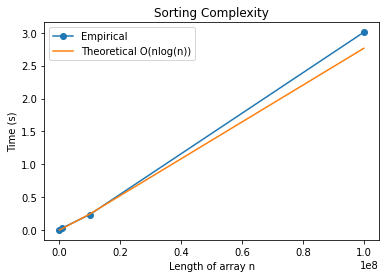

In [3]:
sizes = [1e5, 1e6, 1e7, 1e8]
times = []
for l in sizes:
    start = time.perf_counter()
    np.sort(np.arange(l))
    times += [(time.perf_counter() - start)]
plt.plot(sizes, times, marker='o', label='Empirical')
# Note you may have to play around with the constant
C_SORT = 1.5e-9
plt.plot(sizes, [C_SORT*s * np.log(s) for s in sizes], label='Theoretical O(nlog(n))')
plt.xlabel('Length of array n'); plt.ylabel('Time (s)')
plt.title("Sorting Complexity"); plt.legend()

#### Time/Space Complexity in ML

1. In machine learning (ML), the most important time complexity and space complexity comes down to matrix operations.
2. Thus knowing the time and space complexity of matrix operations and what is practically doable is important for building ML systems.

#### Example: Solving a Linear System

1. Let $A^{(N \times N)}$ be matrix and $b^{(N \times 1)}$ be a vector.
2. Then solving
$$
Ax = b
$$
for $x$ has time complexity $O(N^3)$.

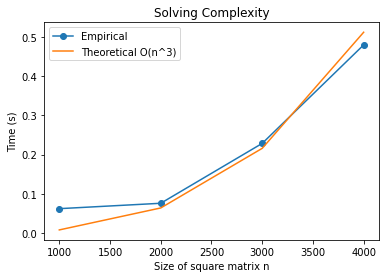

In [4]:
sizes = [int(1e3), int(2e3), int(3e3), int(4e3)]
times = []
for l in sizes:
    diag = np.random.randn(l); A = np.diag(diag); b = np.ones(l)  # Create fake data
    start = time.perf_counter()
    x = np.linalg.solve(A, b)     # Run computation
    times += [(time.perf_counter() - start)]
plt.plot(sizes, times, marker='o', label='Empirical')
# Note you may have to play around with the constant
C_LINSOLV = 8e-12
plt.plot(sizes, [C_LINSOLV*s**3 for s in sizes], label='Theoretical O(n^3)')
plt.xlabel('Size of square matrix n'); plt.ylabel('Time (s)')
plt.title("Solving Complexity"); plt.legend()

In [5]:
n = int(1e6)
print(f"Solving n={n} takes {C_LINSOLV*n**3} seconds, or {C_LINSOLV*n**3/86400} days")

Solving n=1000000 takes 8000000.0 seconds, or 92.5925925925926 days


#### Implication: Linear Regression

1. Reminder that we could solve linear regression using the equation
$$
A^TAx = A^Tb
$$
where $A$ was the data matrix extended with $1s$ in the last column, $b$ were the targets.
2. This means that if we tried to solve a linear regression with $D = 1,000,000$ (the number of dimensions) using the exact linear algebra solution, it would take ~ 92 days on this computer.

#### Implication: Gaussian Process Regression (GPR)

1. Reminder that we could solve gaussian process regression (GPR) using the equation
$$
K(X, X)\alpha = y - \mu(X)
$$
where $K(X, X)$ was the kernel matrix, $\alpha$ were the weights, and $y - \mu(X)$ were the offset targets.
2. This means that if we tried to solve a GPR with $N = 1,000,000$ (the number of points) using the exact linear algebra solution, it would take ~ 92 days on this computer.

#### Example: Solving a Linear System by inverting

1. Let $A^{(N \times N)}$ be matrix and $b^{(N \times 1)}$ be a vector.
2. Then solving
$$
Ax = b
$$
by computing
$$
x = A^{-1}b
$$
has time complexity $O(N^3)$.

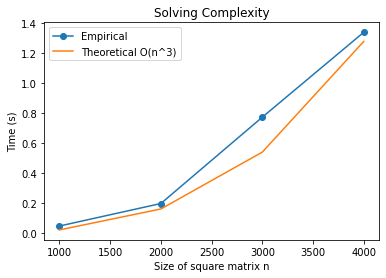

In [6]:
sizes = [int(1e3), int(2e3), int(3e3), int(4e3)]
times = []
for l in sizes:
    diag = np.random.randn(l); A = np.diag(diag); b = np.ones(l)  # Create fake data
    start = time.perf_counter()
    x = np.linalg.inv(A) @ b       # Solve linear equation by inverting matrix
    times += [(time.perf_counter() - start)]
plt.plot(sizes, times, marker='o', label='Empirical')
# Note you may have to play around with the constant
C_INV = 2e-11
plt.plot(sizes, [C_INV*s**3 for s in sizes], label='Theoretical O(n^3)')
plt.xlabel('Size of square matrix n'); plt.ylabel('Time (s)')
plt.title("Solving Complexity"); plt.legend()

In [7]:
print(f"Linear solve is {C_INV / C_LINSOLV} times faster")

Linear solve is 2.5 times faster


#### Takeaway 1: theoretically, constants don't matter, but practically they do

1. Both approaches to solving a linear system take $O(N^3)$ time.
2. However, if you solve a linear system by inverting a matrix and then multipling, then it will take approximately 230 days.
3. Matrix inversion is also less numerically stable than straightforward solve.

#### Takeaway 2: theoretical scalability is not practical scalability

1. You may have learned in theory class that $O(N^3)$ is efficiently solvable in practice.
2. But we have seen that even for solving a system of linear equations, efficiently solvable means that we may have to wait ~92 days on a sufficiently large problem.

#### Practical Consequence

1. **Approximate solutions** are important in practice.
2. This means that we have to give up "accuracy" of some kind.
3. The tradeoff to consider is then whether the savings in time/space is worth the loss in accuracy.

In [8]:
l = 10000
A = np.eye(l); b = np.ones(l)  # Create fake data
start = time.perf_counter()
x = scipy.sparse.linalg.cg(A, b)
time.perf_counter() - start

0.0777984579999611

#### Example: Conjugate Gradient Method

1. Suppose $A$ is positive definite.
2. Then the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) can be used to solve
$$
Ax = b
$$
iteratively and approximately.

Mean absolute error [9.043200665268136, 8271.171119036931, 11586.80923930729, 71987.84861966147]


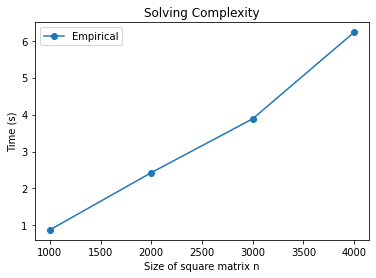

In [9]:
sizes = [int(1e3), int(2e3), int(3e3), int(4e3)]
times = []; maes = []
for l in sizes:
    diag = np.random.randn(l); A = np.diag(diag); b = np.ones(l)  # Create fake data
    start = time.perf_counter()
    # Point 1: Iterative method where we can set convergence threshold
    x, info = scipy.sparse.linalg.cg(A, b, tol=1e-4, maxiter=2000)
    times += [(time.perf_counter() - start)]
    # Point 2: Approximate answer
    maes += [np.sum(np.abs(x - np.linalg.solve(A, b)))]
plt.plot(sizes, times, marker='o', label='Empirical')
# Note you may have to play around with the constant
plt.xlabel('Size of square matrix n'); plt.ylabel('Time (s)')
plt.title("Solving Complexity"); plt.legend()
print("Mean absolute error", maes)

### Tractability

1. There's another reason for approximation, i.e., **analytic tractability**.
2. That is, sometimes, we can't even come up with a formula.

#### Computing Conditional Distributions

1. Suppose we define a probability distribution $p(z, x)$.
2. Next suppose we want to compute the conditional distribution
$$
p(z | x)
$$
3. By Bayes rule we have
$$
p(z | x) = \frac{p(z, x)}{p(x)}
$$
4. Consequently we need to compute the integral
$$
p(x) = \int p(z, x) dz
$$

#### Example: Analytically tractable

Let 
$$
\begin{pmatrix}
y_1 \\
\vdots \\
y_n \\
y^*
\end{pmatrix} \sim
\mathcal{N}\left(
\begin{pmatrix}
\mu(x_1) \\
\vdots \\
\mu(x_n) \\
\mu(x^*)
\end{pmatrix}, 
\begin{pmatrix}
k(x_1, x_1) & \dots & k(x_1, x_n) & k(x_1, x^*) \\
\vdots & \ddots & \vdots & \vdots \\
k(x_n, x_1) & \dots & k(x_n, x_n) & k(x_n, x^*) \\
k(x^*, x_1) & \dots & k(x^*, x_n) & k(x^*, x^*) \\
\end{pmatrix}
\right)
$$
so that $y_i = f(x_i)$ where $f \sim GP(\mu, k)$.

Then the conditional distribution (i.e., the GP posterior)
$$
p(y^* | x^*, x_1, \dots, x_n, y_1, \dots, y_n)
$$
is analytically tractable to compute (but is not be scalable).

#### Example: Analytically intractable distribution on 1-layer neural network parameters

1. Suppose
\begin{align*}
A & \sim \mathcal{N}(0, I) \\
b & \sim \mathcal{N}(0, I) \\
y^i & \sim \mathcal{N}(g(Ax^i + b), 1) \\
\end{align*}
where $g$ is some non-linear function.
2. Then solving
$$
p(A, b | \{y^i, x^i\}_{1 \leq i \leq N})
$$
is not analytically tractable in general.

### Summary

At least two reasons for approximation:
1. Scalability
2. (Analytic) tractability

## Variational Inference

Technique designed for solving analytically intractable conditional probability distributions.

### Basic Idea

1. Construct approximation $q_\theta(z)$ to $p(z | x)$, i.e.,
$$
p(z | x) \approx q_\theta(z)
$$
2. Pick $\theta$ such that it minimizes "distance" between $p(z | x)$ and  $q_\theta(z)$.

### Notion of Distance?

We would like a way to compute the distance between two probability distributions.

#### KL Divergence

1. The **Kullback–Leibler (KL) divergence** is defined as
$$
KL(q, p) = \int q(z)\log\frac{q(z)}{p(z)} dz
$$
where $q$ and $p$ are probability densities.
2. Note that it is not symmetric in its arguments.
3. Thus the KL divergence is technically not a metric.

#### KL Divergence of Discrete Distributions

$$
KL(q, p) = \sum_{z} q(z)\log\frac{q(z)}{p(z)}
$$
where $q$ and $p$ are probability mass functions.

In [10]:
def discrete_kl(q, p):
    tmp = 0.0
    for z in q.support():
        tmp += q.pmf(z) * np.log(q.pmf(z) / p.pmf(z))
    return tmp

Text(0.5, 1.0, 'KL Divergence of Unfair from Fair Coin Flip')

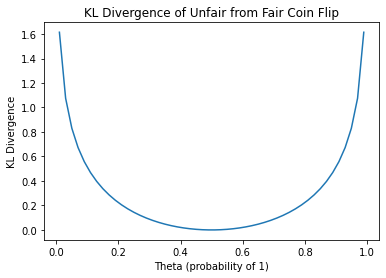

In [11]:
cat = sp.stats.rv_discrete(values=([1, 2],
                                   [1./2., 1./2.]))
thetas = np.linspace(0.01, 0.99); kls = []
for theta in thetas:
    dist = sp.stats.rv_discrete(values=([1, 2],
                                       [theta, 1 - theta]))
    kls += [discrete_kl(cat, dist)]
plt.plot(thetas, kls)
plt.xlabel('Theta (probability of 1)'); plt.ylabel('KL Divergence')
plt.title('KL Divergence of Unfair from Fair Coin Flip')

Text(0.5, 1.0, 'KL Divergence of Fair from Unfair Coin Flip')

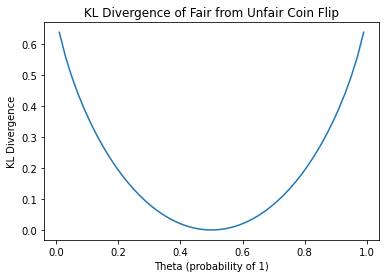

In [12]:
cat = sp.stats.rv_discrete(values=([1, 2],
                                   [1./2., 1./2.]))
thetas = np.linspace(0.01, 0.99); kls = []
for theta in thetas:
    dist = sp.stats.rv_discrete(values=([1, 2],
                                       [theta, 1 - theta]))
    kls += [discrete_kl(dist, cat)]
plt.plot(thetas, kls)
plt.xlabel('Theta (probability of 1)'); plt.ylabel('KL Divergence')
plt.title('KL Divergence of Fair from Unfair Coin Flip')

### Best Approximation?

What does it mean for $q_\theta(x)$ to best approximate $p(z|x)$ now that we have a notion of distance?

#### Rewriting the KL divergence

\begin{align*}
KL(q_\theta, p) & = \int \log\frac{q_\theta(z)}{p(z|x)} q_\theta(z)dz \tag{definition}\\
& = \int \log\frac{q(z)p(x)}{p(z, x)} q_\theta(z)dz \tag{Bayes}\\
& = \int (\log q_\theta(z) - \log p(z, x) + \log p(x)) q_\theta(z)dz \tag{log}\\
& = \log p(x) + \int (\log q_\theta(z) - \log p(z, x)) q_\theta(z)dz \tag{linearity}\\
\end{align*} 

#### Evidence Lower Bound (ELBO)

Thus
$$
\log p(x) = KL(q_\theta, p) - \int (\log q_\theta(z) - \log p(z, x)) q_\theta(z)dz 
$$

1. The term
$$
ELBO(q_\theta, x) = \int (\log q_\theta(z) - \log p(z, x)) q_\theta(z)dz 
$$
is called the **evidence lower bound (ELBO)**.
2. The term
$$
\log p(x)
$$
is called the **log evidence** and is a constant for fixed x.
3. Consequently maximizing the ELBO minimizes the KL divergence.


## Variational Inference on GP Model

### Recall Ordinary GP

In [ ]:
Let $(X, y)$ be a training dataset.
Suppose we have $GP(0, k)$.
The posterior predictive mean is
$$
f^*(x^*) = K_{x^*X}(\sigma^2I + K_{XX})^{-1}y
$$
where $K_{xy} = k(x, y)$ is a kernel matrix.

In [13]:
def jax_squared_exp_kernel(x, y, weight=1.0, length_scale=1.0) -> float:
    scaled_diff = (x - y) / length_scale
    radius2 = jnp.dot(scaled_diff, scaled_diff)
    c = weight * weight
    e = jnp.exp(-0.5 * radius2)
    return c * e

def fit_gp(k, X, y, noise2):
    K_XX = jnp.concatenate([jnp.concatenate([k(x1, x2) for x2 in X], axis=1) for x1 in X])
    K_XX = K_XX + noise2 * jnp.eye(X.shape[0])
    K_XX_inv = jnp.linalg.inv(K_XX)
    return K_XX_inv @ y

def pred_gp(k, alpha, X, x):
    return jnp.concatenate([k(x, x2) for x2 in X], axis=1) @ alpha

def k(x, y):
    return jnp.array([[jax_squared_exp_kernel(x, y)]])

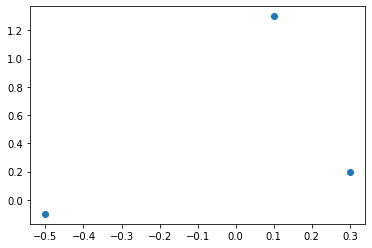

In [14]:
x1 = [0.3]; x2 = [-0.5]; x3 = [.1]                
train_x = jnp.array([x1, x2, x3])
train_y = jnp.array([0.2, -.1, 1.3])
plt.plot(train_x[:,0], train_y, marker='o', linestyle='none')

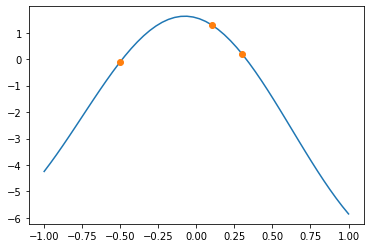

In [15]:
alpha = fit_gp(k, train_x, train_y, 1e-5)
xs = jnp.linspace(-1, 1)
ys = [pred_gp(k, alpha, train_x, x) for x in xs]
plt.plot(xs, ys)
plt.plot(train_x[:,0], train_y, marker='o', linestyle='none')

### GP with inducing points 

Let
1. $y$ is the output with noise at $X$
2. $f$ is the output without noise at $X$
3. $u$ is the inducing output at $Z$

Then
$$
p(y, f, u) = p(y|f) p(f|u) p(u)
$$
where
1. $p(y|f) = \mathcal{N}(y | f, \sigma^2I)$
2. $p(f|u) = \mathcal{N}(f | K_{XZ}K_{ZZ}^{-1}u, K_{XX} - K_{XZ}K_{ZZ}^{-1}K_{ZX})$
3. $p(u) = \mathcal{N}(u | 0, K_{ZZ})$

Note that
$$
p(f, u) = \mathcal{N} \left(f, u | 0, 
\begin{pmatrix}
K_{XX} & K_{XZ} \\
K_{ZX} & K_{ZZ}
\end{pmatrix}
\right)
$$

#### Variational Approximation 1

1. Choose
$$
q(f, u) \approx p(f, u | y)
$$
2. We will minimize
$$
KL(q(f, u) || p(f, u | y)
$$
3. Note that
$$
p(f, u | y) = p(f | u) p(u | y)
$$
for an optimal setting of $u$.
4. Thus
$$
q(f, u) = p(f | u) q(u)
$$

#### Variational Approximation 2

Note that
\begin{align*}
ELBO(q) & = \int p(f|u)q(u) \log \frac{p(y|f)p(f|u)p(u)}{p(f|u)q(u)} dfdu \\
& = \int q(f, u) \log \frac{p(y|f)p(u)}{q(u)}  dfdu \\
& = \int (\log p(y|f) + \log p(u) - \log q(u)) q(f, u)  dfdu \\
& = \int \log p(y|f) q(f, u) dfdu + \int (\log p(u) - \log q(u)) q(f, u) dfdu \\
& = \int \log p(y|f)q(f) df + \int (\log p(u) - \log q(u))q(u) du \\
& = \mathbb{E}_{q(f)} \log p(y|f) - KL(q(u) || p(u))
\end{align*}

The reason for this refactoring that we can jointly optimize Z, m, and A.

#### Variational Approximation 3

Consequently we need to compute
1. $KL(q(u) || p(u))$. As a reminder,
    1. $q(u) = \mathcal{N}(u | m, A)$
    2. $p(u) = \mathcal{N}(u | 0, K_{ZZ})$
2. $\mathbb{E}_{q(f)} \log p(y|f)$
    1. Note that
$$
q(f, u) = \mathcal{N}(
\begin{pmatrix}
f \\
u \\
\end{pmatrix} |
\begin{pmatrix}
K_{XZ}K_{ZZ}^{-1}m \\
m \\
\end{pmatrix},
\begin{pmatrix}
K_{XX} + K_{XZ}K_{ZZ}^{-1}(A - K_{ZZ})K_{ZZ}^{-1}K_{ZX} & K_{XZ}K_{ZZ}^{-1}A \\
AK_{ZZ}^{-1}K_{ZX} & A \\
\end{pmatrix}
)
$$
We can check that this agrees with the conditional distribution of $p(f|u)$ by the conditional property of multivariate normals and $q(u)$ by the marginal property of multivariate normals. 
    2. Thus
\begin{align*}
    q(f) & = \mathcal{N}(K_{XZ}K_{ZZ}^{-1}m, K_{XX} + K_{XZ}K_{ZZ}^{-1}(A - K_{ZZ})K_{ZZ}^{-1}K_{ZX})
\end{align*} 
    3. Consequently
\begin{align*}
\mathbb{E}_{q(f)} \log p(y|f) & = \int \log p(y|f) q(f) df \\
& = \int \log \mathcal{N}(y | f, \sigma^2I) q(f) df \\
& = \int \sum_{i=1}^D -.5 (\log(2\pi\sigma^2) + (y_i - f_i)^2/\sigma^2 ) q(f_i) df_i \\
& = -.5 \sum_{i=1}^D \left( (\log(2\pi\sigma^2) + \frac{1}{\sigma^2}((y_i - \mu_i)^2 +  \Sigma_{ii})) \right) \\
\end{align*}
where
$\mu = K_{XZ}K_{ZZ}^{-1}m$ and $\Sigma = K_{XX} + K_{XZ}K_{ZZ}^{-1}(A - K_{ZZ})K_{ZZ}^{-1}K_{ZX}$

In [20]:
def kl_normal(mu0, L_sigma0, mu1, L_sigma1):
    D = L_sigma0.shape[0]
    log_det_sigma0 = 2.*jnp.sum(jnp.log(jnp.diag(L_sigma0)))
    log_det_sigma1 = 2.*jnp.sum(jnp.log(jnp.diag(L_sigma1)))
    c = - D + log_det_sigma1 - log_det_sigma0
    inv_L_sigma1 = jnp.linalg.inv(L_sigma1)
    mu_diff = mu1 - mu0
    return 0.5 * (jnp.trace(inv_L_sigma1.transpose() @ inv_L_sigma1 @ L_sigma0 @ L_sigma0.transpose()) + mu_diff.transpose() @ inv_L_sigma1.transpose() @ inv_L_sigma1 @ mu_diff + c)

In [21]:
def elbo_variational_gp(X, y, k, noise, Z, m, LA):
    K_ZZ = jnp.concatenate([jnp.concatenate([k(z1, z2) for z2 in Z], axis=1) for z1 in Z])
    K_XZ = jnp.concatenate([jnp.concatenate([k(x, z) for z in Z], axis=1) for x in X])
    K_ZX = K_XZ.transpose()
    L_ZZ = jnp.linalg.cholesky(K_ZZ)
    inv_L_ZZ = jnp.linalg.inv(L_ZZ)
    inv_L_ZZ_T = inv_L_ZZ.transpose()
    inv_K_ZZ = jnp.linalg.inv(K_ZZ)
    mu = (K_XZ @ inv_L_ZZ_T) @ (inv_L_ZZ @ m)
        
    # sigma = K_XX + K_XZ @ inv_K_ZZ @ (A - K_ZZ) @ inv_K_ZZ @ K_ZX
    K_XX = jnp.concatenate([jnp.concatenate([k(x1, x2) for x2 in X], axis=1) for x1 in X])
    A = LA @ LA.transpose()
    sigma = K_XX + (K_XZ @ inv_L_ZZ_T) @ inv_L_ZZ @ (A - K_ZZ) @ inv_L_ZZ_T @ (inv_L_ZZ @ K_ZX)
    
    elp = -.5 * jnp.sum((((y - mu) ** 2 + jnp.diag(sigma)) / noise + jnp.log(2*jnp.pi) + jnp.log(noise)))
    return elp - kl_normal(m, LA, jnp.zeros(m.shape[0]), L_ZZ)

In [22]:
Z = train_x
m = jnp.zeros(Z.shape[0])
LA = jnp.eye(Z.shape[0])
lr = 0.000005
for i in range(10):
    dZ, dm, dLA = jax.jacrev(elbo_variational_gp, argnums=(4,5,6))(train_x, train_y, k, 1e-5, Z, m, LA)
    # Z = Z + lr*dZ
    m = m + lr*dm
    LA = LA + lr*dLA
print(train_x)
print(Z, m, LA @ LA.transpose())

[[ 0.3]
 [-0.5]
 [ 0.1]]
[[ 0.3]
 [-0.5]
 [ 0.1]] [ 0.20111114 -0.09946298  1.2970725 ] [[ 1.00480283e-05 -1.90651921e-08  7.69516006e-08]
 [-1.90651921e-08  1.00599755e-05  2.54206967e-08]
 [ 7.69516006e-08  2.54206967e-08  1.00403531e-05]]


### Variational GP: inducing points are training set

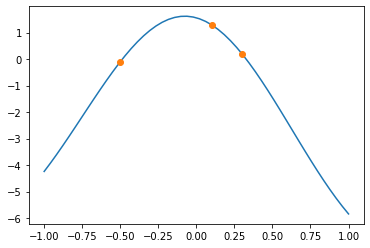

In [24]:
def pred_vgp(k, m, A, Z, x):
    K_ZZ = jnp.concatenate([jnp.concatenate([k(z1, z2) for z2 in Z], axis=1) for z1 in Z])
    K_ZZ_inv = jnp.linalg.inv(K_ZZ)
    
    K_xZ = jnp.concatenate([k(x, z) for z in Z], axis=1)
    return K_xZ @ K_ZZ_inv @ m

xs = jnp.linspace(-1, 1)
ys = [pred_vgp(k, m, LA @ LA.transpose(), Z, x) for x in xs]
plt.plot(xs, ys)
plt.plot(train_x[:,0], train_y, marker='o', linestyle='none')

### Variational GP: inducing points are not training set

In [30]:
Z = jnp.array([x1, x2])
m = jnp.zeros(Z.shape[0])
LA = jnp.eye(Z.shape[0])
lr = 0.000005
for i in range(10):
    dZ, dm, dLA = jax.jacrev(elbo_variational_gp, argnums=(4,5,6))(train_x, train_y, k, 1e-5, Z, m, LA)
    Z = Z + lr*dZ
    m = m + lr*dm
    LA = LA + lr*dLA
print(jnp.array([x1, x2]), Z)
print(train_x)
print(Z, m, LA @ LA.transpose())

[[ 0.3]
 [-0.5]] [[ 0.20851225]
 [-0.5425385 ]]
[[ 0.3]
 [-0.5]
 [ 0.1]]
[[ 0.20851225]
 [-0.5425385 ]] [0.7034535  0.04140661] [[ 5.3571489e-06 -5.9628251e-06]
 [-5.9628251e-06  2.2064041e-05]]


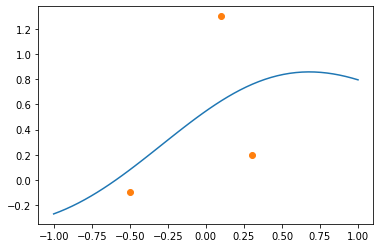

In [31]:
xs = jnp.linspace(-1, 1)
ys = [pred_vgp(k, m, LA @ LA.transpose(), Z, x) for x in xs]
plt.plot(xs, ys)
plt.plot(train_x[:,0], train_y, marker='o', linestyle='none')

### Variational GP: learning inducing points

[[ 0.3]
 [-0.5]
 [ 0.1]]
[[ 0.3]
 [-0.5]] [0.7452703  0.08039232] [[ 6.6298435e-06 -3.2539149e-06]
 [-3.2539149e-06  1.0251323e-05]]


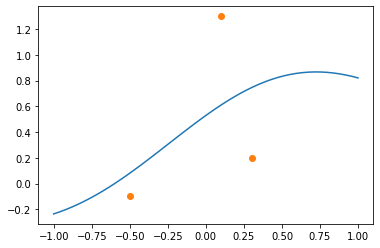

In [32]:
Z = jnp.array([x1, x2])
m = jnp.zeros(Z.shape[0])
LA = jnp.eye(Z.shape[0])
lr = 0.000005
for i in range(10):
    dZ, dm, dLA = jax.jacrev(elbo_variational_gp, argnums=(4,5,6))(train_x, train_y, k, 1e-5, Z, m, LA)
    # Z = Z + lr*dZ
    m = m + lr*dm
    LA = LA + lr*dLA
print(train_x)
print(Z, m, LA @ LA.transpose())

xs = jnp.linspace(-1, 1)
ys = [pred_vgp(k, m, A, Z, x) for x in xs]
plt.plot(xs, ys)
plt.plot(train_x[:,0], train_y, marker='o', linestyle='none')

## Scaling Gaussian Processes with Derivative Information Using Variational Inference

### Abstract

1. Problem: GPs with derivatives have $O(N^3D^3)$ training complexity where N is the number of points and D is the number of dimensions.
2. The paper introduces a way to achieve fully scalable Gaussian process regression with derivatives using variational inference.
3. The approach is demonstrated using high dimensional stellarator fusion regression task to training graph convolutional neural networks on Pubmed using Bayesian optimization. 
4. Interesting fact: this method improves GP regresssion even if derivative information is not available.

### Introduction

1. Develop a scalable method for GP regression with derivatives: "We introduce a novel method to scale Gaussian processes with derivative information using stochastic variational approximations. We show that the expected log likelihood term of the Evidence LowerBound (ELBO) decomposes as a sum over both training labels and individual partial derivatives. This lets us use stochastic gradient descent with minibatches comprised of arbitrary subsets of both label and derivative information. Just as variational GPs with inducing points replace the training label information with a set of learned inducing values, we show how to sparsify the derivative information with a set of inducing directional derivatives. The resulting algorithm requires only $O(M^3p^3)$ time per iteration of training, where $M \ll N$ and $p \ll D$."
2. It works on a variety of datasets and tasks: "We demonstrate the quality of our approximate model by comparing to both exact GPs with derivative information and DSKI from [5] on a variety of synthetic functions and a surface reconstruction task considered by [5]. We then demonstrate the full scalability of our model on a variety of tasks that are well beyond existing solutions, including training a graph convolutional neural network [16] on Pubmed [28] with Bayesian optimization and regression on a large scale Stellarator fusion dataset with derivatives. We then additionally show that, surprisingly, our variational Gaussian process model augmented with inducing directional derivatives can achieve performance improvements in the regression setting even when no derivative information is available in the training set."

### Conclusion

1. "We introduce a novel method for achieving fully scalable — scalable in N and D — GPs with derivative information by leveraging stochastic variational approximations."
    - "The resulting model reduces the cost of training GPs with derivatives to $O(M^3p^3)$ time per iteration of training, where $M \ll N$ and $p \ll D$."
    - "A practical limitation of our method is that M, p must be small enough for fast computations, which is not a reasonable assumption in very high dimensional problems."
2. "Lastly, we show that our methods can even have benefit in the regression setting when no derivative information is available in the training set, by including a new avenue to encode information. While this last result is a surprising benefit of GPs with derivatives, it is not well understood and is thus a good direction for future study."

### Experiments


#### Implicit Surface Reconstruction

<img src="media/bunny.png" alt="bunny.png" width="400"/>

#### Graph Convolutional Neural Network

<img src="media/gcn.png" alt="gcn.png" width="400"/>

#### Stellarator and Rover

<img src="media/stellarator-rover.png" alt="stellarator-rover.png" width="400"/>

#### Ablation Study on p

<img src="media/ablation-p.png" alt="ablation-p.png" width="400"/>

#### No Derivative

<img src="media/no-derivative.png" alt="no-derivative.png" width="400"/>

#### Approximate Further with Variational Inference

<img src="media/svgp.png" alt="svgp.png" width="600"/>

### Methods

#### Naive GP with Derivatives with Inducing Points

We can approximate this distribution as
$$
p(y, \nabla y | X) \approx p(y | u, \nabla u, X, Z) p(u, \nabla u | Z)
$$
where we can think of $Z$ as a set of **inducing** points, $u$ as the corresponding value of the GP at the inducing points, and $\nabla u$ as the corresponding gradient value of the GP at the inducing points.

#### Naive GP with Derivatives with Inducing Points Variational Distribution

<img src="media/gpdq.png" alt="gpdq.png" width="600"/>

Note that this is already implemented by swapping in the derivative kernel!

#### Naive GP with Derivatives with Inducing Points ELBO

<img src="media/gpd-elbo.png" alt="gpd-elbo.png" width="600"/>

#### Directional Deriviatives

1. Instead of representing a derivative in it's entirety, we can project the derivative in a direction.
2. The **directional derivative** in the direction $v$ is $\nabla f \cdot v$.

#### Directional Derivative Kernel

<img src="media/directional-kernel1.png" alt="directional-kernel1.png" width="600"/>
<img src="media/directional-kernel2.png" alt="directional-kernel1.png" width="600"/>

#### Directional Derivative Variational Distribution and ELBO

<img src="media/directional-elbo.png" alt="directional-elbo.png" width="600"/>

## Summary

1. Scalability and tractability are two important issues in practical machine learning.
2. We saw how inducing points could be used to address scalability and variational inference can be used to address tractability and scalability.
3. We saw a scalable GP that could fit derivatives.